In [1]:
import pandas as pd
import numpy as np
import spacy
import os
from pathlib import Path
from importlib import reload

In [56]:
import source.prepare_data as prd
import source.dataset as dat
import source.multi_layer_perceptron as mlp
import source.table as tb
import source.comparision as comp
import source.recurent_neural_networks as rnn

In [73]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>

In [110]:
"""
1) Preprocessing
"""
# load models and dataset
df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/train.csv", nrows=5000)
nlp = spacy.load("en_core_web_sm")

# prepare dataset
df = prd.prepare_df(df, nlp)

# create dataset out of cleaned columns
dataset = dat.Text_Dataset(df, col_text="clean_text_str", col_label="sentiment", args={"max_features":5000})
dataset.split_dataset()


In [111]:
df

,sentiment,clean_text,clean_text_str,text
0,1,"[love, you, toooooo, TG, LOL, Gngb]",love you toooooo TG LOL Gngb,@tonigirl14 love you toooooo ! ! TG LOL Gngb
1,0,"[I, tell, myself, do, click, on, this, link, b...",I tell myself do click on this link but I just...,@jun6lee I told myself : Do n't click on this ...
2,0,"[the, man, who, render, his, voice, to, Mickey...",the man who render his voice to Mickey Mouse e...,The man who rendered his voice to Mickey Mouse...
3,1,"[I, think, red, would, be, nice, or, maybe, yo...",I think red would be nice or maybe you could d...,@Shontelle_Layne I think red would be nice . ...
4,0,"[I, guess, one, of, her, tweet, say, she, be, ...",I guess one of her tweet say she be confused,@Silverlines - I guess . 'Cause one of her twe...
...,...,...,...,...
4995,1,"[I, have, a, friend, birthday, that, and, I, b...",I have a friend birthday that and I be attend ...,@gedulous I have a friend 's 21st birthday tha...
4996,0,"[not, really]",not really,@rosatifanda not really ..
4997,1,"[happy, mother, day]",happy mother day,@cocoancream happy mothers day
4998,1,"[I, m, drag, daddy, round, the, shop, today]",I m drag daddy round the shop today,i m dragging daddy round the shops today


In [112]:
"""
2) Accuracy analysis for MLP model. We will compare the workflow of MLP by using TD-IDF encoding and BOW encoding

2.1) TD-IDF encoding
"""
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = dataset.get_encodings(tdidf=True)

mlp_tdidf_params = mlp.find_best_mlp(X_train=X_train_TF,
                                      Y_train=Y_train_TF,
                                      X_test=X_test_TF,
                                      Y_test=Y_test_TF,
                                      n_trials = 3)

[I 2025-06-17 22:28:14,495] A new study created in memory with name: mlp_optimization
[I 2025-06-17 22:28:26,340] Trial 0 finished with values: [1.2080209255218506, 0.6890000104904175] and parameters: {'epochs': 162, 'learning_rate': 0.3747296728815349, 'units': 3}.
[I 2025-06-17 22:28:35,114] Trial 1 finished with values: [0.8146413564682007, 0.6930000185966492] and parameters: {'epochs': 110, 'learning_rate': 0.27620714812311087, 'units': 9}.
[I 2025-06-17 22:28:50,061] Trial 2 finished with values: [0.5607364177703857, 0.7350000143051147] and parameters: {'epochs': 194, 'learning_rate': 0.06890165523872267, 'units': 6}.


In [113]:
mlp_tdidf_params

,loss,accuracy,params_epochs,params_learning_rate,params_units,time,name
0,1.208021,0.689,162,0.374730,3,11.843970,MLP_BOW
1,0.814641,0.693,110,0.276207,9,8.772484,MLP_BOW
2,0.560736,0.735,194,0.068902,6,14.946299,MLP_BOW


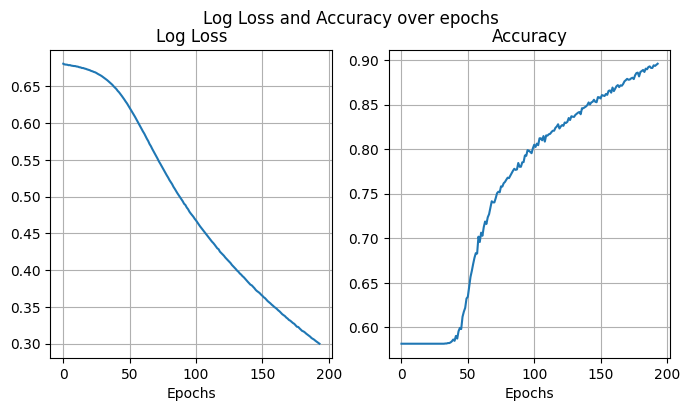

In [115]:
mlp_tdidf = mlp.Feedforward_Model(X_train_TF, Y_train_TF, units=mlp_tdidf_params.iloc[-1]['params_units']) # the last one is the best one
mlp_tdidf.train(LR=mlp_tdidf_params.iloc[-1]['params_learning_rate'], epochs=mlp_tdidf_params.iloc[-1]['params_epochs'])
mlp_tdidf.plot_loss_accuracy()

In [116]:
# Do some tests for vocab size
mlp_tdidf_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding TDIDF.
Params: 0.06890165523872267, 194, 6
Test started........
The result is: [(1000, 0.729), (2000, 0.72), (3000, 0.708), (4000, 0.738), (5000, 0.745), (6000, 0.722), (7000, 0.714), (8000, 0.726)]


In [34]:
# Tests for split ratio
mlp_tdidf_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding TDIDF.
Params: 0.303028353746933, 120, 4
Test started.....
The result is: [(0.1, 0.71), (0.2, 0.705), (0.3, 0.7067), (0.4, 0.6825), (0.5, 0.658)]


In [36]:
"""
2.2) BOW encoding
"""
X_train_BOW, X_test_BOW, Y_train_BOW, Y_test_BOW = dataset.get_encodings(tdidf=False)

mlp_bow_params = mlp.find_best_mlp(X_train=X_train_BOW,
                                      Y_train=Y_train_BOW,
                                      X_test=X_test_BOW,
                                      Y_test=Y_test_BOW,
                                      n_trials = 3)

[I 2025-06-17 20:47:32,471] A new study created in memory with name: mlp_optimization
[I 2025-06-17 20:47:33,963] Trial 0 finished with values: [0.6339978575706482, 0.6520000100135803] and parameters: {'epochs': 113, 'learning_rate': 0.060881811083585445, 'units': 8}.
[I 2025-06-17 20:47:36,161] Trial 1 finished with values: [1.0376701354980469, 0.6759999990463257] and parameters: {'epochs': 187, 'learning_rate': 0.24306754504049394, 'units': 5}.
[I 2025-06-17 20:47:37,699] Trial 2 finished with values: [0.7885016798973083, 0.6740000247955322] and parameters: {'epochs': 122, 'learning_rate': 0.16896564514441376, 'units': 9}.


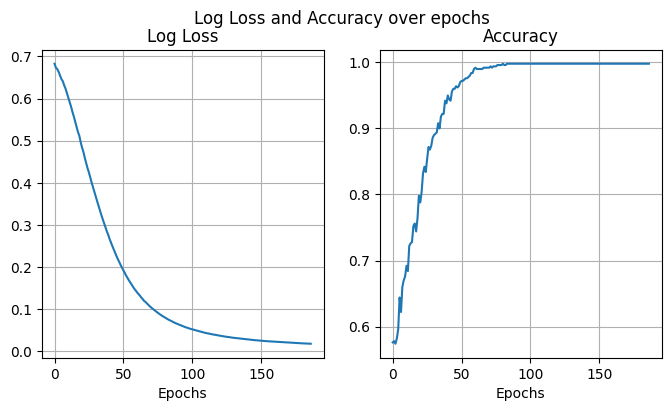

In [37]:
mlp_bow = mlp.Feedforward_Model(X_train_BOW, Y_train_BOW, units=mlp_bow_params.iloc[-1]['params_units'])
mlp_bow.train(LR=mlp_bow_params.iloc[-1]['params_learning_rate'], epochs=mlp_bow_params.iloc[-1]['params_epochs'])
mlp_bow.plot_loss_accuracy()

In [38]:
# Do some tests for vocab size
mlp_bow_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding BOW.
Params: 0.24306754504049394, 187, 5
Test started........
The result is: [(1000, 0.69), (2000, 0.67), (3000, 0.655), (4000, 0.72), (5000, 0.71), (6000, 0.635), (7000, 0.675), (8000, 0.67)]


In [39]:
# Tests for split ratio
mlp_bow_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding BOW.
Params: 0.24306754504049394, 187, 5
Test started.....
The result is: [(0.1, 0.73), (0.2, 0.655), (0.3, 0.71), (0.4, 0.68), (0.5, 0.69)]


In [67]:
"""
2.3) classical RNN with embedding encoding
"""
X_train_EBM, X_test_EBM, Y_train_EBM, Y_test_EBM = dataset.get_sequences(vocab_size=1000, maxlen=10)

In [68]:
rnn_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=3)

[I 2025-06-17 21:31:02,273] A new study created in memory with name: mlp_optimization


Epoch 1/108
3/3 [==============================] - 1s 61ms/step - loss: 0.7150 - accuracy: 0.4859 - val_loss: 0.6835 - val_accuracy: 0.6000
Epoch 2/108
3/3 [==============================] - 0s 10ms/step - loss: 0.6917 - accuracy: 0.5719 - val_loss: 0.6834 - val_accuracy: 0.5938
Epoch 3/108
3/3 [==============================] - 0s 9ms/step - loss: 0.6865 - accuracy: 0.5672 - val_loss: 0.6764 - val_accuracy: 0.6125
Epoch 4/108
3/3 [==============================] - 0s 10ms/step - loss: 0.6682 - accuracy: 0.6609 - val_loss: 0.6781 - val_accuracy: 0.6062
Epoch 5/108
3/3 [==============================] - 0s 9ms/step - loss: 0.6375 - accuracy: 0.6687 - val_loss: 0.6698 - val_accuracy: 0.6000
Epoch 6/108
3/3 [==============================] - 0s 9ms/step - loss: 0.5799 - accuracy: 0.7000 - val_loss: 0.6789 - val_accuracy: 0.5875
Epoch 7/108
3/3 [==============================] - 0s 10ms/step - loss: 0.5288 - accuracy: 0.7453 - val_loss: 0.7060 - val_accuracy: 0.5500
Epoch 8/108
3/3 [======

[I 2025-06-17 21:31:05,388] Trial 0 finished with values: [1.9179309606552124, 0.5049999952316284] and parameters: {'epochs': 108, 'learning_rate': 0.06290012616545763, 'units': 9, 'two_layers': False, 'batch_size': 235}.


Epoch 1/169
4/4 [==============================] - 1s 47ms/step - loss: 0.7071 - accuracy: 0.4875 - val_loss: 0.6763 - val_accuracy: 0.5938
Epoch 2/169
4/4 [==============================] - 0s 7ms/step - loss: 0.6536 - accuracy: 0.6141 - val_loss: 0.7635 - val_accuracy: 0.5063
Epoch 3/169
4/4 [==============================] - 0s 6ms/step - loss: 0.5634 - accuracy: 0.7234 - val_loss: 0.8511 - val_accuracy: 0.4812
Epoch 4/169
4/4 [==============================] - 0s 7ms/step - loss: 0.4695 - accuracy: 0.7859 - val_loss: 0.9748 - val_accuracy: 0.4875
Epoch 5/169
4/4 [==============================] - 0s 7ms/step - loss: 0.3718 - accuracy: 0.8562 - val_loss: 1.0259 - val_accuracy: 0.4875
Epoch 6/169
4/4 [==============================] - 0s 7ms/step - loss: 0.3173 - accuracy: 0.9000 - val_loss: 1.4156 - val_accuracy: 0.4625
Epoch 7/169
4/4 [==============================] - 0s 7ms/step - loss: 0.2632 - accuracy: 0.9109 - val_loss: 1.5005 - val_accuracy: 0.4500
Epoch 8/169
4/4 [=========

[I 2025-06-17 21:31:10,506] Trial 1 finished with values: [1.1698013544082642, 0.5350000262260437] and parameters: {'epochs': 169, 'learning_rate': 0.1004004811966321, 'units': 7, 'two_layers': False, 'batch_size': 194}.


Epoch 1/136
8/8 [==============================] - 1s 17ms/step - loss: 0.7052 - accuracy: 0.5234 - val_loss: 0.6841 - val_accuracy: 0.6062
Epoch 2/136
8/8 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5500 - val_loss: 0.6912 - val_accuracy: 0.5437
Epoch 3/136
8/8 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6359 - val_loss: 0.6739 - val_accuracy: 0.5938
Epoch 4/136
8/8 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6141 - val_loss: 0.7282 - val_accuracy: 0.5500
Epoch 5/136
8/8 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.6500 - val_loss: 0.7619 - val_accuracy: 0.4688
Epoch 6/136
8/8 [==============================] - 0s 3ms/step - loss: 0.6082 - accuracy: 0.6250 - val_loss: 0.7620 - val_accuracy: 0.5688
Epoch 7/136
8/8 [==============================] - 0s 3ms/step - loss: 0.5771 - accuracy: 0.6969 - val_loss: 0.7742 - val_accuracy: 0.5250
Epoch 8/136
8/8 [=========

[I 2025-06-17 21:31:14,901] Trial 2 finished with values: [0.8035666942596436, 0.46000000834465027] and parameters: {'epochs': 136, 'learning_rate': 0.17772390885287684, 'units': 5, 'two_layers': False, 'batch_size': 91}.


In [69]:
rnn_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,name
0,0.803567,0.460,91,136,0.177724,False,5,4.394051,RNN_EBM
1,1.917931,0.505,235,108,0.062900,False,9,3.113653,RNN_EBM
2,1.169801,0.535,194,169,0.100400,False,7,5.116779,RNN_EBM


In [71]:
rnn_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=rnn_emb_params.iloc[-1]['params_units'],
                              rnn_type="RNN",
                              two_layers=rnn_emb_params.iloc[-1]['params_two_layers'])

rnn_ebm.train(LR=rnn_emb_params.iloc[-1]['params_learning_rate'],
              epochs=rnn_emb_params.iloc[-1]['params_epochs'],
              batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)


Epoch 1/169
4/4 [==============================] - 1s 40ms/step - loss: 0.7288 - accuracy: 0.4953 - val_loss: 0.6798 - val_accuracy: 0.6187
Epoch 2/169
4/4 [==============================] - 0s 7ms/step - loss: 0.6199 - accuracy: 0.6609 - val_loss: 0.8247 - val_accuracy: 0.4250
Epoch 3/169
4/4 [==============================] - 0s 7ms/step - loss: 0.6758 - accuracy: 0.5641 - val_loss: 0.7373 - val_accuracy: 0.5312
Epoch 4/169
4/4 [==============================] - 0s 7ms/step - loss: 0.5919 - accuracy: 0.6641 - val_loss: 0.7569 - val_accuracy: 0.5500
Epoch 5/169
4/4 [==============================] - 0s 7ms/step - loss: 0.5633 - accuracy: 0.7188 - val_loss: 0.8060 - val_accuracy: 0.5312
Epoch 6/169
4/4 [==============================] - 0s 7ms/step - loss: 0.4976 - accuracy: 0.7563 - val_loss: 0.7929 - val_accuracy: 0.5500
Epoch 7/169
4/4 [==============================] - 0s 7ms/step - loss: 0.4814 - accuracy: 0.7656 - val_loss: 0.8297 - val_accuracy: 0.5312
Epoch 8/169
4/4 [=========

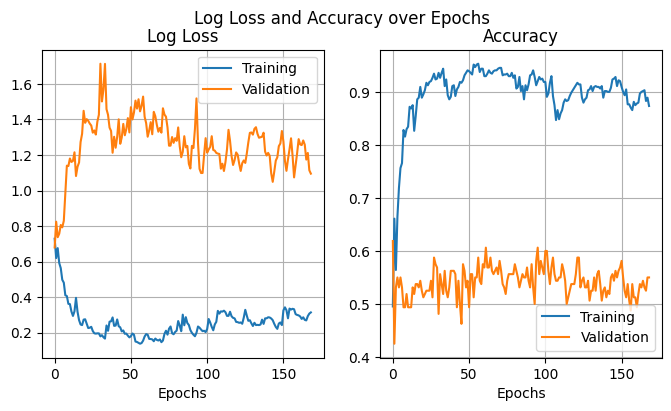

In [72]:
rnn_ebm.plot_loss_accuracy()

In [80]:
rnn_ebm_split = comp.test_split_ratio(dataset,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for RNN, with embedding EBM.
Params: 0.1004004811966321, 169, 7
Test started.....
The result is: [(0.1, 0.53), (0.2, 0.52), (0.3, 0.5), (0.4, 0.55), (0.5, 0.528)]


In [92]:
rnn_ebm_vocab = comp.test_vocab_size(df,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for RNN, with embedding EBM.
Params: 0.1004004811966321, 169, 7
Test started........
The result is: [(1000, 0.56), (2000, 0.535), (3000, 0.635), (4000, 0.525), (5000, 0.605), (6000, 0.585), (7000, 0.54), (8000, 0.52)]


In [108]:
"""
3) Upload data to the class for comparison
"""
table = tb.Table()
table.add_record(name="rnn_emb",
                 epoch=rnn_emb_params.iloc[-1]["params_epochs"],
                 lr=rnn_emb_params.iloc[-1]["params_learning_rate"],
                 units=rnn_emb_params.iloc[-1]["params_units"],
                 avg_time=rnn_emb_params.iloc[-1]["time"],
                 batch_size=rnn_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=rnn_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=rnn_ebm_split,
                 vocab_accuracy=rnn_ebm_vocab)

table.add_record(name="mlp_tdidf",
                 epoch=mlp_tdidf_params.iloc[-1]["params_epochs"],
                 lr=mlp_tdidf_params.iloc[-1]["params_learning_rate"],
                 units=mlp_tdidf_params.iloc[-1]["params_units"],
                 avg_time=mlp_tdidf_params.iloc[-1]["time"],
                 split_accuracy=mlp_tdidf_split,
                 vocab_accuracy=mlp_tdidf_vocab)

Adding a new record with params: name: rnn_emb, epoch: 169, lr: 0.1004004811966321, units: 7, average time: 5.116779
Adding a new record with params: name: mlp_tdidf, epoch: 120, lr: 0.303028353746933, units: 4, average time: 1.787404


In [109]:
table.show(tabulate_view=False)


Table info:
<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2 non-null      object 
 1   epochs          2 non-null      int64  
 2   lr              2 non-null      float64
 3   units           2 non-null      int64  
 4   avg_time        2 non-null      float64
 5   split_accuracy  2 non-null      object 
 6   vocab_accuracy  2 non-null      object 
 7   two_layers      2 non-null      int64  
 8   batch_size      2 non-null      int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 160.0+ bytes

Records preview:


,name,epochs,lr,units,avg_time,split_accuracy,vocab_accuracy,two_layers,batch_size
0,rnn_emb,169,0.100400,7,5.116779,"[(0.1, 0.53), (0.2, 0.52), (0.3, 0.5), (0.4, 0...","[(1000, 0.56), (2000, 0.535), (3000, 0.635), (...",0,194
1,mlp_tdidf,120,0.303028,4,1.787404,"[(0.1, 0.71), (0.2, 0.705), (0.3, 0.7067), (0....","[(1000, 0.69), (2000, 0.705), (3000, 0.695), (...",0,0


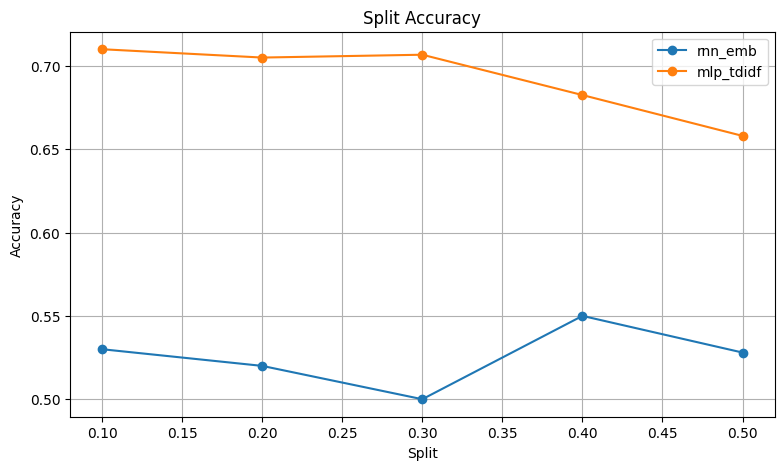

In [103]:
table.plot_split_accuracy()

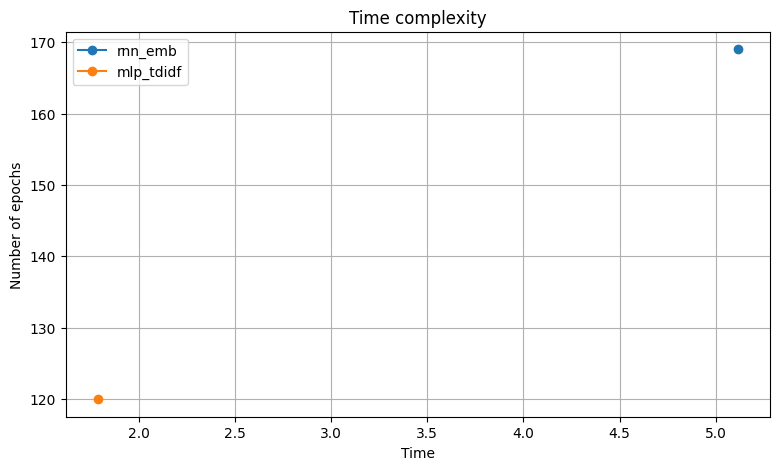

In [104]:
table.plot_time_complexity()

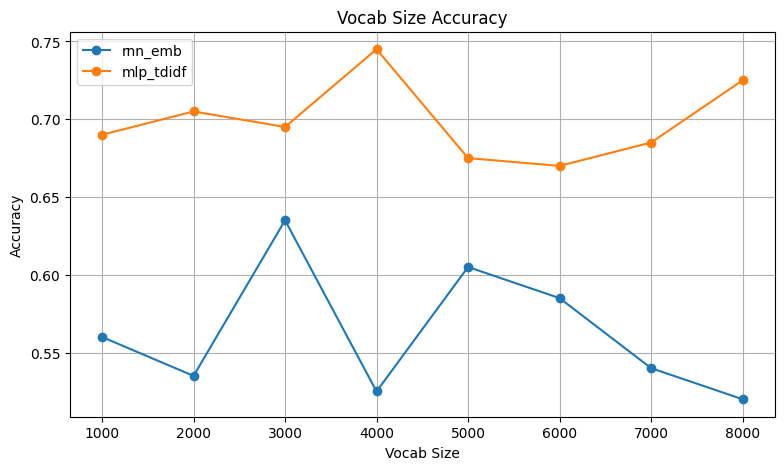

In [105]:
table.plot_vocab_accuracy()

In [100]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>